# Movement data analysis

Analyze the movement data collected during the experiment

## Import data and libraries

In [25]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
from branca.colormap import linear
from geolib import geohash as geolib
import json
import math
import random
import arc_drawer
import numpy as np
import pydeck as pdk

In [26]:
# Defined legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 300px; 
                 background-color: white; border:2px solid grey; z-index:9999; 
                 font-size:14px;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; Walking &nbsp; <i class="fa fa-square" style="color:#7FC97F"></i><br>
     &nbsp; On Bicycle &nbsp; <i class="fa fa-square" style="color:#BDAED4"></i><br>
     &nbsp; Train &nbsp; <i class="fa fa-square" style="color:#FDBF85"></i><br>
     &nbsp; Bus &nbsp; <i class="fa fa-square" style="color:#FFFF99"></i><br>
     &nbsp; Electric Bus &nbsp; <i class="fa fa-square" style="color:#FFFF99"></i><br>
     &nbsp; Car &nbsp; <i class="fa fa-square" style="color:#386CB0"></i><br>
     &nbsp; Tram &nbsp; <i class="fa fa-square" style="color:#F0027F"></i><br>
     &nbsp; Plane &nbsp; <i class="fa fa-square" style="color:#BE5B17"></i><br>
     &nbsp; Boat &nbsp; <i class="fa fa-square" style="color:#BE5B17"></i><br>
      </div>
     '''

In [27]:

# Read the data from the csv
df = gpd.read_file('data/Test_movements.csv')
df

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
0,1199121CX,2024-09-03 11:28:03+00:00,2024-09-03 11:30:07+00:00,u0m44x,u0m44x,518,ON_BICYCLE,ON_BICYCLE,2,False,None
1,1199121CX,2024-09-03 15:12:18+00:00,2024-09-03 15:17:23+00:00,u0m44x,u0m44x,359,WALKING,WALKING,0,False,None
2,1199121CX,2024-09-03 15:52:14+00:00,2024-09-03 15:59:24+00:00,u0m44x,u0m468,416,WALKING,WALKING,0,False,None
3,1199121CX,2024-09-03 15:59:25+00:00,2024-09-03 16:21:34+00:00,u0m468,u0m464,3091,ELECTRIC_BUS,ELECTRIC_BUS,197,False,None
4,4L5S1E,2024-09-03 16:23:18+00:00,2024-09-03 16:25:21+00:00,u0m709,u0m70d,570,ON_BICYCLE,ON_BICYCLE,3,False,None
...,...,...,...,...,...,...,...,...,...,...,...
11324,9P3WXJ,2025-03-18 07:48:47+00:00,2025-03-18 07:52:59+00:00,u0m44x,u0m44y,1476,ELECTRIC_CAR,ELECTRIC_CAR,131,False,None
11325,9P3WXJ,2025-03-18 07:54:33+00:00,2025-03-18 08:05:11+00:00,u0m44y,u0m468,2123,BUS,BUS,280,False,None
11326,1L3E1K,2025-03-18 06:52:02+00:00,2025-03-18 08:27:31+00:00,u0mqpu,u0qnnq,87756,TRAIN,TRAIN,614,False,None
11327,11Z11DXG,2025-03-18 06:33:36+00:00,2025-03-18 07:21:01+00:00,u0mupv,u0qjd1,35096,TRAIN,TRAIN,245,False,None


In [28]:
# Show df with time without +00:00
df['start_time'] = df['start_time'].str[:-6]
df['end_time'] = df['end_time'].str[:-6]
df

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
0,1199121CX,2024-09-03 11:28:03,2024-09-03 11:30:07,u0m44x,u0m44x,518,ON_BICYCLE,ON_BICYCLE,2,False,None
1,1199121CX,2024-09-03 15:12:18,2024-09-03 15:17:23,u0m44x,u0m44x,359,WALKING,WALKING,0,False,None
2,1199121CX,2024-09-03 15:52:14,2024-09-03 15:59:24,u0m44x,u0m468,416,WALKING,WALKING,0,False,None
3,1199121CX,2024-09-03 15:59:25,2024-09-03 16:21:34,u0m468,u0m464,3091,ELECTRIC_BUS,ELECTRIC_BUS,197,False,None
4,4L5S1E,2024-09-03 16:23:18,2024-09-03 16:25:21,u0m709,u0m70d,570,ON_BICYCLE,ON_BICYCLE,3,False,None
...,...,...,...,...,...,...,...,...,...,...,...
11324,9P3WXJ,2025-03-18 07:48:47,2025-03-18 07:52:59,u0m44x,u0m44y,1476,ELECTRIC_CAR,ELECTRIC_CAR,131,False,None
11325,9P3WXJ,2025-03-18 07:54:33,2025-03-18 08:05:11,u0m44y,u0m468,2123,BUS,BUS,280,False,None
11326,1L3E1K,2025-03-18 06:52:02,2025-03-18 08:27:31,u0mqpu,u0qnnq,87756,TRAIN,TRAIN,614,False,None
11327,11Z11DXG,2025-03-18 06:33:36,2025-03-18 07:21:01,u0mupv,u0qjd1,35096,TRAIN,TRAIN,245,False,None


In [29]:
# Count distinct participant_ids
df['participant_id'].nunique()

52

In [30]:
# Remove 2 last characters of geohash
#df['start_geohash'] = df['start_geohash'].str[:-1]
#df['end_geohash'] = df['end_geohash'].str[:-1]

In [31]:
## Convert distance to int
df['distance(m)'] = df['distance(m)'].astype(int)

## Convert gCO2 to int
df['gCO2'] = df['gCO2'].astype(int)

In [32]:
# Get data with mode_of_transport = "PLANE" and original_mode_of_transport = "CAR"
df[(df['mean_of_transport'] == 'PLANE') & (df['original_mean_of_transport'] == 'CAR')]

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
925,4L5S1E,2024-10-05 01:47:44,2024-10-05 03:02:26,drt3pc,drzh36,301978,PLANE,CAR,79420,False,None


In [33]:
## Get a list of all the unique participants in df, including the number of occurrences of each participant
participants = df['participant_id'].value_counts()
participants

participant_id
4L5S1E       1772
9B11R1G       874
8G2B2C        864
219827XMX     706
119817XU1     665
5U3B1R        630
6M9B3S        536
1L3E1K        456
6F10L1F       455
3G8GXJ        373
8N7L1U        323
6R9HXD        289
12C6B1D       273
10F11M1A      261
12C8M2J       240
3B10M2A       218
2L7HXA        210
2L1M1R        187
9F2AXJ        183
9P3WXJ        168
5F6GXO        148
7C3E1I        142
7O12A1M       136
11L5W1P       119
9B6T1M        119
4C5PXH        115
11Z11DXG      103
0W1M6R        100
1F9H2J         60
1F3EXR         51
11H6C1Y        47
219935XE1      47
6S5T1H         45
1199121CX      40
6Z11P2C        37
9L2RXF         37
1G3GXM         36
10W12MXM       35
10V1G4T        33
119963XR1      31
219957XAX      30
2F1S2P         30
8G2B1C         24
220092XJ1      13
5F11B1P        13
4K5D1A         13
9W2ZXI         11
12F10D1A       10
8A1A2H          7
1A10MXP         5
3M2B2K          5
0H2T3S          4
Name: count, dtype: int64

In [34]:
## Get the list of movements with each mean of transport
df['mean_of_transport'].value_counts()

mean_of_transport
WALKING            4781
TRAIN              1875
ON_BICYCLE         1438
CAR                 996
ELECTRIC_BIKE       708
BUS                 492
ELECTRIC_BUS        379
ELECTRIC_CAR        350
TRAM                191
DETECTION_ERROR      45
HYBRID_CAR           41
SCOOTER              10
PLANE                 9
COACH                 9
BOAT                  3
BOAT_NO_ENGINE        2
Name: count, dtype: int64

In [35]:
# Get the distance covered with each mean of transport (in km)
df.groupby('mean_of_transport')['distance(m)'].sum()/1000

mean_of_transport
BOAT                  25.805
BOAT_NO_ENGINE         4.756
BUS                 1525.572
CAR                19448.784
COACH                232.556
DETECTION_ERROR      241.469
ELECTRIC_BIKE       1742.467
ELECTRIC_BUS         705.406
ELECTRIC_CAR       11233.692
HYBRID_CAR           664.208
ON_BICYCLE          3311.115
PLANE              48719.992
SCOOTER               12.119
TRAIN              63645.508
TRAM                 439.727
WALKING             4422.292
Name: distance(m), dtype: float64

In [36]:
# Transform the start_ and end_date to a date only
df['start_time_precise'] = pd.to_datetime(df['start_time'])#.dt.date
df['end_time_precise'] = pd.to_datetime(df['end_time'])#.dt.date

df['start_time'] = pd.to_datetime(df['start_time']).dt.date
df['end_time'] = pd.to_datetime(df['end_time']).dt.date

df['duration'] = (df['end_time_precise'] - df['start_time_precise']).dt.total_seconds()

In [37]:
df.groupby(['participant_id', 'mean_of_transport', 'start_time'])['distance(m)'].sum()/1000

participant_id  mean_of_transport  start_time
0H2T3S          BUS                2025-01-28     8.568
                TRAIN              2025-01-28    49.134
                WALKING            2025-01-28     2.052
0W1M6R          CAR                2024-10-18    20.533
                                   2024-10-20    73.184
                                                  ...  
9W2ZXI          CAR                2025-01-31    64.552
                                   2025-02-03    31.377
                                   2025-02-04    21.895
                TRAIN              2025-02-04    95.710
                WALKING            2025-02-04     0.354
Name: distance(m), Length: 4753, dtype: float64

In [38]:
# Get the distance covered by each mean of transport per day, per user. On the days where the user used the mean of transport.
dist_per_day = df.groupby(['participant_id', 'mean_of_transport', 'start_time'])['distance(m)'].sum()


# Get the average per mean of transport across all users. Which means the average of the average_dist
mean_daily = dist_per_day.groupby('mean_of_transport').mean()
std_daily = dist_per_day.groupby('mean_of_transport').std()

# Merge and print
daily = pd.concat([mean_daily, std_daily], axis=1)
daily.columns = ['mean', 'std']
daily


,mean,std
mean_of_transport,,
BOAT,8.601667e+03,8.947384e+03
BOAT_NO_ENGINE,2.378000e+03,7.368053e+02
BUS,4.358777e+03,6.460734e+03
CAR,3.754592e+04,6.923381e+04
COACH,7.751867e+04,7.037702e+04
DETECTION_ERROR,8.943296e+03,1.454216e+04
ELECTRIC_BIKE,6.550628e+03,6.564876e+03
ELECTRIC_BUS,3.014556e+03,3.426842e+03
ELECTRIC_CAR,7.247543e+04,1.229274e+05


In [39]:
dist_per_day = dist_per_day.reset_index()

In [40]:
# Plot as a violin plot
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_50012/1236318022.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_of_transport', y='distance(m)', data=dist_per_day, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis')


<Axes: xlabel='mean_of_transport', ylabel='distance(m)'>

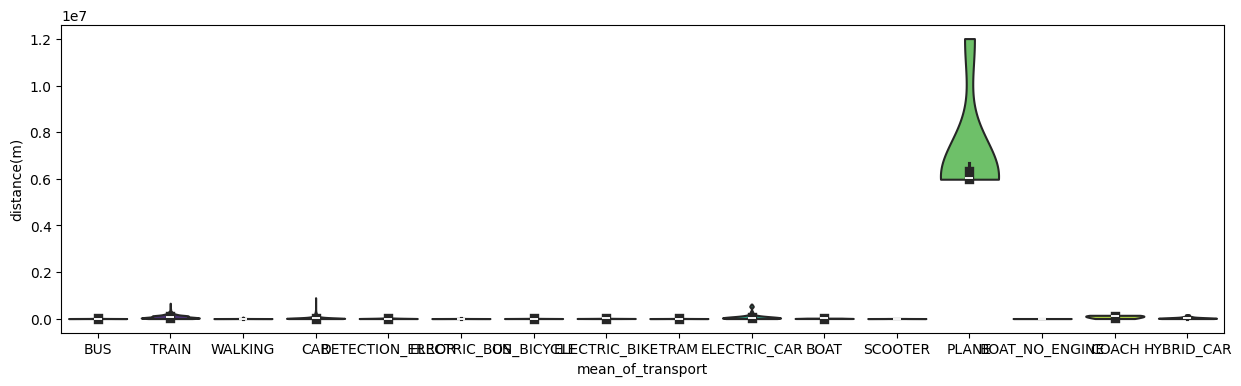

In [41]:
# Plot as violin plot
plt.figure(figsize=(15, 4))
sns.violinplot(x='mean_of_transport', y='distance(m)', data=dist_per_day, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis')

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_50012/1446108219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_of_transport', y='distance(m)', data=long, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Long distance
/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_50012/1446108219.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_of_transport', y='distance(m)', data=short, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Short distance


<Axes: xlabel='mean_of_transport', ylabel='distance(m)'>

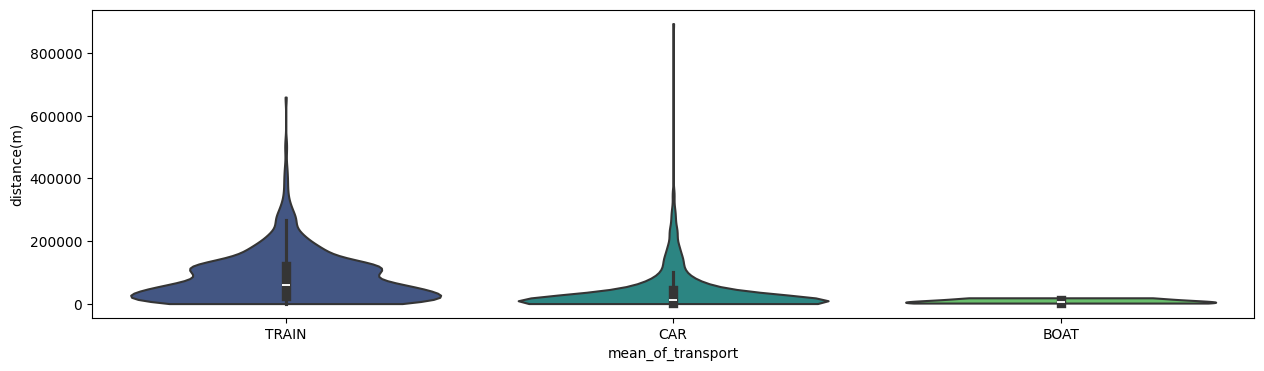

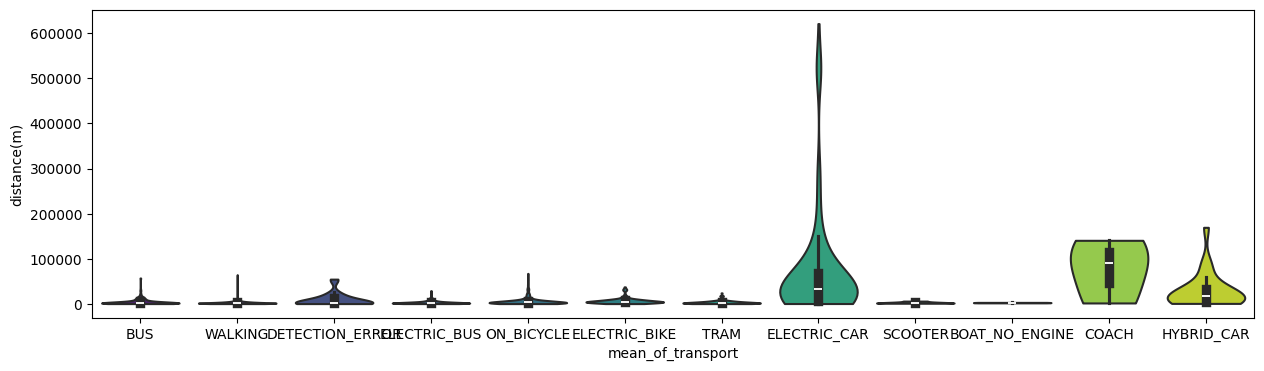

In [42]:
# Separate car, train, boat from the rest and plot
long = dist_per_day[dist_per_day['mean_of_transport'].isin(['CAR', 'TRAIN', 'BOAT'])]
short = dist_per_day[~dist_per_day['mean_of_transport'].isin(['CAR', 'TRAIN', 'BOAT', 'PLANE'])]

plt.figure(figsize=(15, 4))
sns.violinplot(x='mean_of_transport', y='distance(m)', data=long, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Long distance

plt.figure(figsize=(15, 4))
sns.violinplot(x='mean_of_transport', y='distance(m)', data=short, inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='viridis') # Short distance

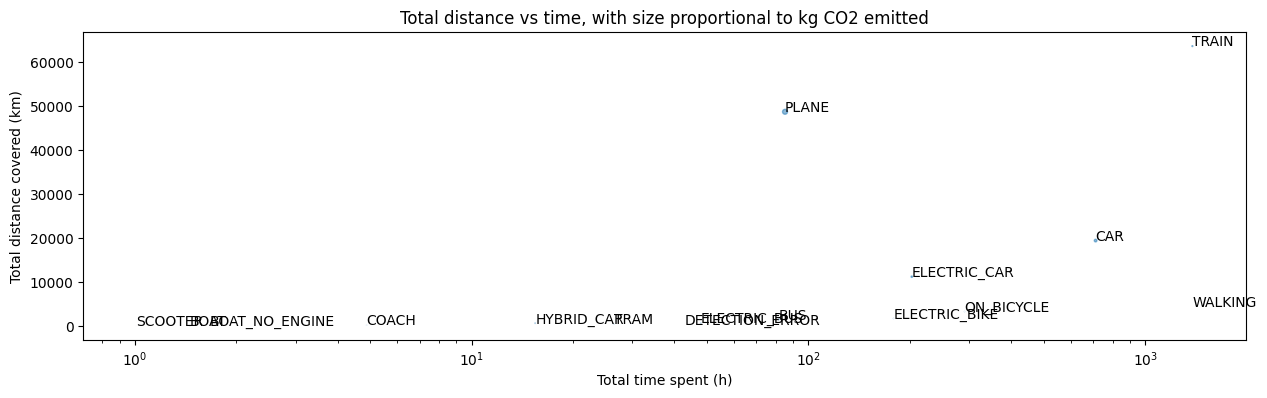

In [49]:
# Compute total distance covered by each mean of transport
total_dist = df.groupby('mean_of_transport')['distance(m)'].sum()/1000

# Compute total time spent by each mean of transport, in hours
total_time = df.groupby('mean_of_transport')['duration'].sum()/3600

# Compute total gCO2 emitted by each mean of transport
total_gCO2 = df.groupby('mean_of_transport')['gCO2'].sum()/1000

# Plot total distance vs time, with size proportional to gCO2
plt.figure(figsize=(15, 4))
plt.scatter(total_time, total_dist, s=total_gCO2/1000, alpha=0.5)
plt.xlabel('Total time spent (h)')
plt.ylabel('Total distance covered (km)')
plt.title('Total distance vs time, with size proportional to kg CO2 emitted')

plt.xscale('log')

# Add legend to each dot
for i, txt in enumerate(total_dist.index):
    plt.annotate(txt, (total_time[i], total_dist[i]))

plt.show()

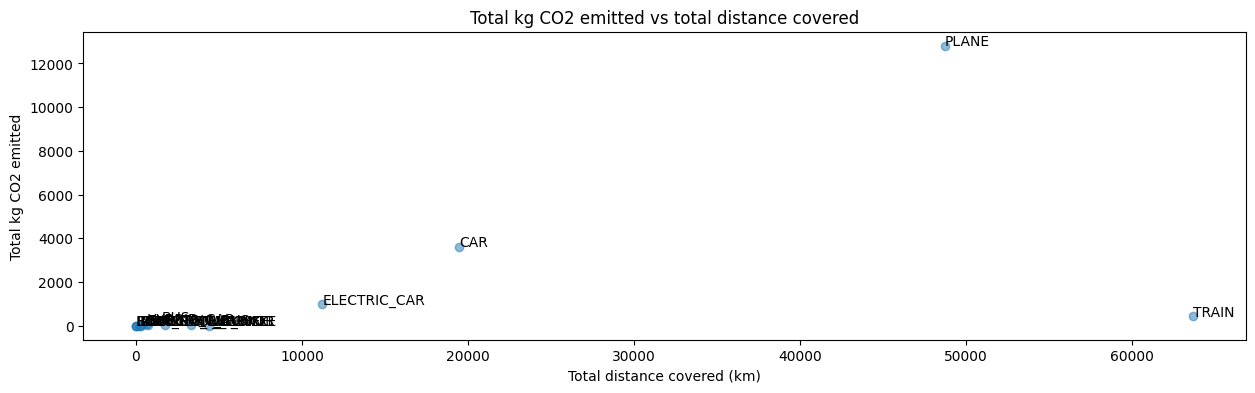

In [50]:
# Plot gCo2 vs distance
plt.figure(figsize=(15, 4))
plt.scatter(total_dist, total_gCO2, alpha=0.5)
plt.xlabel('Total distance covered (km)')
plt.ylabel('Total kg CO2 emitted')
plt.title('Total kg CO2 emitted vs total distance covered')

# Add legend to each dot
for i, txt in enumerate(total_dist.index):
    plt.annotate(txt, (total_dist[i], total_gCO2[i]))

plt.show()

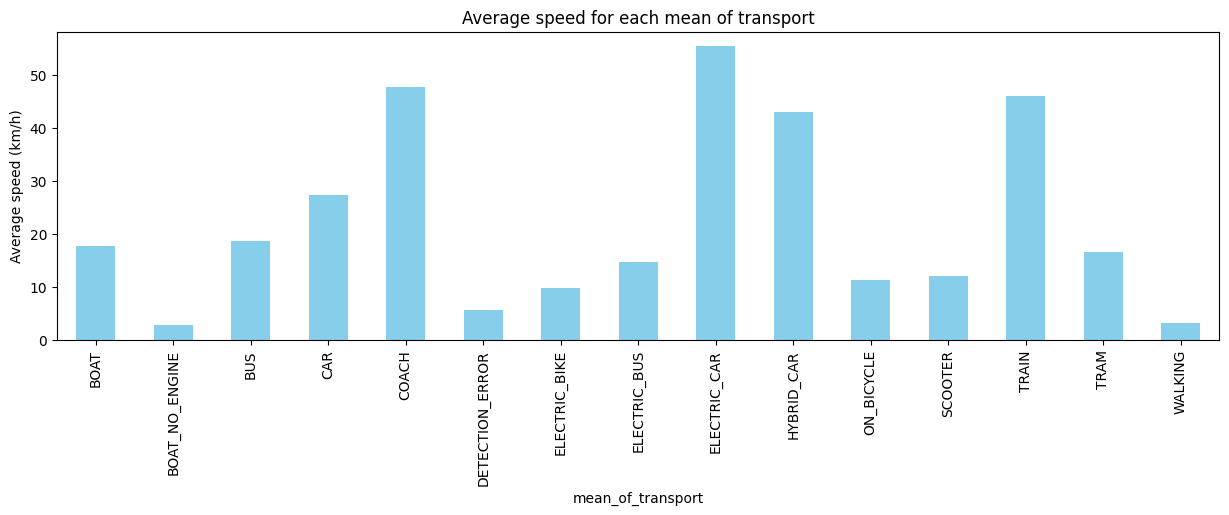

In [58]:
# Plot average speed for each mean of transport in bar plot (except for plane)
average_speed = total_dist/total_time
average_speed = average_speed.drop('PLANE')

plt.figure(figsize=(15, 4))
average_speed.plot(kind='bar', color='skyblue')
plt.ylabel('Average speed (km/h)')
plt.title('Average speed for each mean of transport')
plt.show()

## Create a visualization of the covered routes

In [197]:
## Get a coordinate from a geohash, adding a small random offset to avoid overlapping
def geohash_to_coordinate(geohash):
    try:
        lat, lon = geolib.decode(geohash)
        #lat = float(lat) + 0.00000001#(random.random() - 0.5) * 0.00000001
        #lon = float(lon) + 0.00000001#(random.random() - 0.5) * 0.00000001
        return [float(lat), float(lon)]
    except:
        return [float(0.0), float(0.0)]

In [54]:
## Draw a path from start_geohash to end_geohash on a folium map
def draw_path(start_geohash, end_geohash, mean_of_transport, map, weight=1, tooltip=None):
    ## Give a different color to each mean of transport
    colors = {
        'WALKING': '#7FC97F',
        'ON_BICYCLE': '#BDAED4',
        'ELECTRIC_BIKE': '#BDAED4',
        'SCOOTER': '#BDAED4',
        'TRAIN': '#FDBF85',
        'BUS': '#FFFF99',
        'ELECTRIC_BUS': '#FFFF99',
        'CAR': '#386CB0',
        'ELECTRIC_CAR': '#386CB0',
        'HYBRID_CAR': '#386CB0',
        'TRAM': '#F0027F',
        'PLANE': '#BE5B17',
        'BOAT': '#BE5B17',
        'BOAT_NO_ENGINE': '#BE5B17',
        'DETECTION_ERROR': '#000000',
        'COACH': '#FFFF99',
    }

    try:
        start_coord = geohash_to_coordinate(start_geohash)
        end_coord = geohash_to_coordinate(end_geohash)

        # Add a small offset to avoid overlapping
        start_coord[0] += (random.random() - 0.5) * 0.001
        start_coord[1] += (random.random() - 0.5) * 0.001
        end_coord[0] += (random.random() - 0.5) * 0.001
        end_coord[1] += (random.random() - 0.5) * 0.001

        #arc_drawer.draw_arc(map, start_coord[0], start_coord[1], end_coord[0], end_coord[1], color=colors[mean_of_transport], weight = weight)

        folium.PolyLine(locations=[start_coord, end_coord], color=colors[mean_of_transport], weight=weight, tooltip=tooltip).add_to(map)
    except Exception as e:
        print(e)
        print(start_geohash, end_geohash)


In [21]:
## Create the actual folium map
m = folium.Map(location=[46.9446011, 7.4143311], zoom_start=6, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')

# Count the number of movements with the same combination of start_geohash and end_geohash (or vice-versa)
df['start_end_geohash'] = df['start_geohash'] + df['end_geohash']
df['end_start_geohash'] = df['end_geohash'] + df['start_geohash']

## Get the number of movements with the same combination of start_geohash and end_geohash (or vice-versa)
start_end = df['start_end_geohash'].value_counts()
end_start = df['end_start_geohash'].value_counts()

## Create a list with the sum of the two previous lists, when the index is the same
combined = {}

for index, row in start_end.items():
    if index in end_start:
        combined[index] = row + end_start[index]
    else:
        combined[index] = row

for index, row in end_start.items():
    if index not in combined:
        combined[index] = row

## Convert combined to series
combined = pd.Series(combined)

# Log scaling
combined = combined.apply(lambda x: math.log(x) + 1)

# Draw path for each movement in start_end
for index, row in combined.items():
    start_geohash = index[0:len(index)//2]
    end_geohash = index[len(index)//2:len(index)] 

    try:
        mean_of_transport = df.loc[(df['start_geohash'] == start_geohash) & (df['end_geohash'] == end_geohash), 'mean_of_transport'].iloc[0]
    except:
        mean_of_transport = df.loc[(df['end_geohash'] == start_geohash) & (df['start_geohash'] == end_geohash), 'mean_of_transport'].iloc[0]

    draw_path(start_geohash, end_geohash, mean_of_transport, m, weight = row/max(combined)*7)

## Draw a path for each movement
#for index, row in df.iterrows():
#    draw_path(row['start_geohash'], row['end_geohash'], row['mean_of_transport'], m)

## Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

## Save the map as an html file
m.save('maps/paths_map.html')


## Create a heatmap of the locations visited

In [22]:
## Extract from df a list of all start_geohashes and end_geohashes
geohashes = list(df['start_geohash']) + list(df['end_geohash'])
len(geohashes)

19848

In [23]:
# If we want, we can remove some characters from the end of each geohash to reduce the precision
geohashes = [geohash[:-1] for geohash in geohashes]

In [24]:
# Convert the list of geohashes to a dataframe
geohashes_df = gpd.GeoDataFrame(geohashes, columns=['geohash'])

## Convert the list of geohashes to a geoJSON object


In [25]:
## Convert geohashes to a heatmap in geojson format
def geohashes_to_heatmap(df):
    # Get the distinct geohashes and their counts from the dataframe
    geohashes = df['geohash'].value_counts()

    # Get the maximum count of any geohash
    max_count = math.log(geohashes.max())

    # Convert the geohashes to a list of lists, each containing the geohash and its count
    geohashes = [[geohash, count] for geohash, count in zip(geohashes.index, geohashes)]
    
    # Create a color scale for the heatmap
    color_scale = linear.RdYlBu_10.scale(1, max_count)

    # Convert geohashes to features for geoJSON
    features = []

    for geohash in geohashes:
        # Get the bounds of the geohash
        bounds = geolib.bounds(geohash[0])
        color = color_scale(math.log(geohash[1]))

        # Create a feature for the geohash
        features.append({
            "type": "Feature",
            "properties": {
                "id": geohash[0],
                "fillColor": color,
                "fillOpacity": 0.6,
                "stroke": False
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bounds.sw.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.sw.lat]
                ]]
            },
        })

    # Convert the geohashes to a heatmap in geojson format
    return {
        "type" : "FeatureCollection",
        "features": features
    }

In [26]:
# Convert the geohashes to a heatmap in geojson format
heatmap = geohashes_to_heatmap(geohashes_df)

# Save GeoJSON with double quotes
with open('results/heatmap.geojson', 'w') as f:
    json.dump(heatmap, f)

In [27]:
# Visualize as a heatmap using Folium
# Create a folium map centered at an initial location
def create_map(geojson, mapname, legend=None):
    m = folium.Map(location=[46.9446011, 7.4143311],zoom_start=6, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')

    # Define a style function to set the color of the polygon
    def style_function(feature):
        return {
            'fillColor': feature["properties"]["fillColor"],  # Change this to the desired color
            'stroke': feature["properties"]["stroke"],
            'fillOpacity': feature["properties"]["fillOpacity"],
        }

    # Add GeoJSON data to the map with the style function
    folium.GeoJson(
        geojson,
        name='Polygon Layer',
        style_function=style_function,
    ).add_to(m)

    # Add Layer Control to the map
    folium.LayerControl().add_to(m)

    if legend:
        m.get_root().html.add_child(folium.Element(legend))

    # Save or display the map
    m.save("maps/"+mapname)


In [28]:
create_map(heatmap, "heatmap.html")

In [29]:
!open -a Arc maps/heatmap.html

## Get the map of the most used vehicles

In [ ]:
## Get the list of geohashes with the corresponding mean of transport
geohashes = df[['start_geohash', 'mean_of_transport']].copy()
## Append the end_geohashes to the list of geohashes
geohashes = gpd.GeoDataFrame(pd.concat([geohashes, df[['end_geohash', 'mean_of_transport']]]))
## Merge start_geohashes and end_geohashes into a single column
geohashes['geohash'] = geohashes['start_geohash'].combine_first(geohashes['end_geohash'])
## Remove the start_geohashes and end_geohashes columns
geohashes = geohashes[['geohash', 'mean_of_transport']]

## Reduce precision of geohashes
geohashes['geohash'] = geohashes['geohash'] #.str[:-1]

geohashes

In [ ]:
## Find the mean of transport that occurs the more often for each geohash and keep only the first one (the most used)
geohashes_df = gpd.GeoDataFrame(geohashes, columns=['geohash', 'mean_of_transport'])
# Get the count of the mean of transport for each geohash
geohashes_df = geohashes_df.groupby(['geohash', 'mean_of_transport']).size().reset_index(name='counts')
# For each geohash, keep only the mean of transport that occurs the most often
geohashes_df = geohashes_df.sort_values('counts', ascending=False).drop_duplicates(['geohash'])
# Remove the counts column
#geohashes_df = geohashes_df[['geohash', 'mean_of_transport']]
geohashes_df

In [60]:
## Convert geohashes to a heatmap in geojson format
def heatmap_mot(df):
    ## Give a different color to each mean of transport
    colors = {
        'WALKING': '#7FC97F',
        'ON_BICYCLE': '#BDAED4',
        'ELECTRIC_BIKE': '#BDAED4',
        'SCOOTER': '#BDAED4',
        'TRAIN': '#FDBF85',
        'BUS': '#FFFF99',
        'ELECTRIC_BUS': '#FFFF99',
        'CAR': '#386CB0',
        'ELECTRIC_CAR': '#386CB0',
        'HYBRID_CAR': '#386CB0',
        'TRAM': '#F0027F',
        'PLANE': '#BE5B17',
        'BOAT': '#BE5B17'
    }

    # Convert geohashes to features for geoJSON
    features = []

    for geohash in df:
        # Get the bounds of the geohash
        bounds = geolib.bounds(geohash[0])
        color = colors[geohash[1]]

        # Create a feature for the geohash
        features.append({
            "type": "Feature",
            "properties": {
                "id": geohash[0],
                "fillColor": color,
                "fillOpacity": 0.8,
                "stroke": False
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bounds.sw.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.sw.lat]
                ]]
            },
        })

    # Convert the geohashes to a heatmap in geojson format
    return {
        "type" : "FeatureCollection",
        "features": features
    }

In [ ]:
# Convert the means of transport to a heatmap in geojson format
heatmap = heatmap_mot(geohashes_df.values)

# Save GeoJSON with double quotes
with open('results/heatmap_mot.geojson', 'w') as f:
    json.dump(heatmap, f)

In [97]:
create_map(heatmap, "heatmap_mot.html", legend_html)

In [98]:
!open -a Arc maps/heatmap_mot.html

## Get the map of the movements (start to end point)

In [27]:
# Now we should create a map with lines between the geohashes, with the color of the line corresponding to the mean of transport
# We should also create a legend for the map

## Create the actual folium map
m = folium.Map(location=[46.9446011, 7.4143311], zoom_start=8, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')
# Draw a path for each movement
for index, row in df.iterrows():
    draw_path(row['start_geohash'], row['end_geohash'], row['mean_of_transport'], m, weight = 2, tooltip=row['participant_id'])


## Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

## Save the map as an html file
m.save('maps/paths_map_mot.html')

!open -a Arc maps/paths_map_mot.html

/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


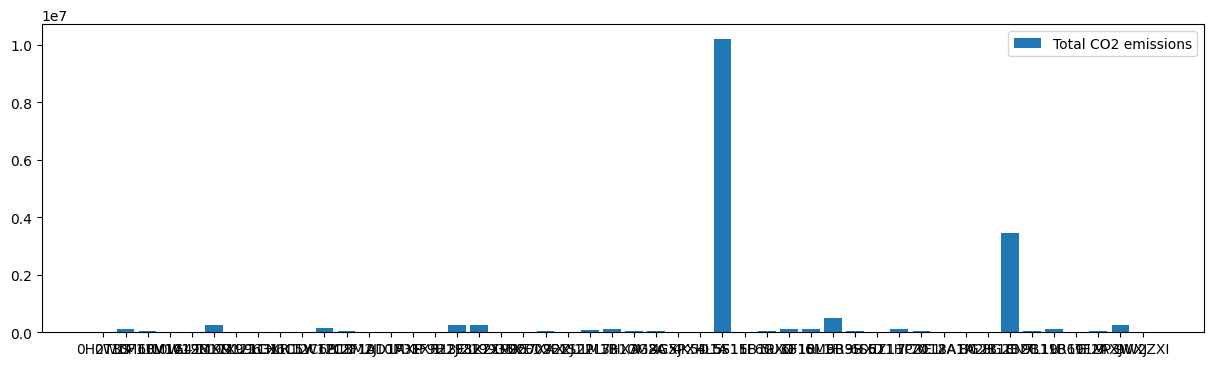

In [60]:
# Compute the total CO2 emissions for each person
df_co2 = df.groupby('participant_id')['gCO2'].sum()

# Plot the total CO2 emissions for each person in a bar plot, together with the average CO2 emissions per km in different bars
plt.figure(figsize=(15, 4))
plt.bar(df_co2.index, df_co2, label='Total CO2 emissions')
plt.legend()
plt.show()

/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


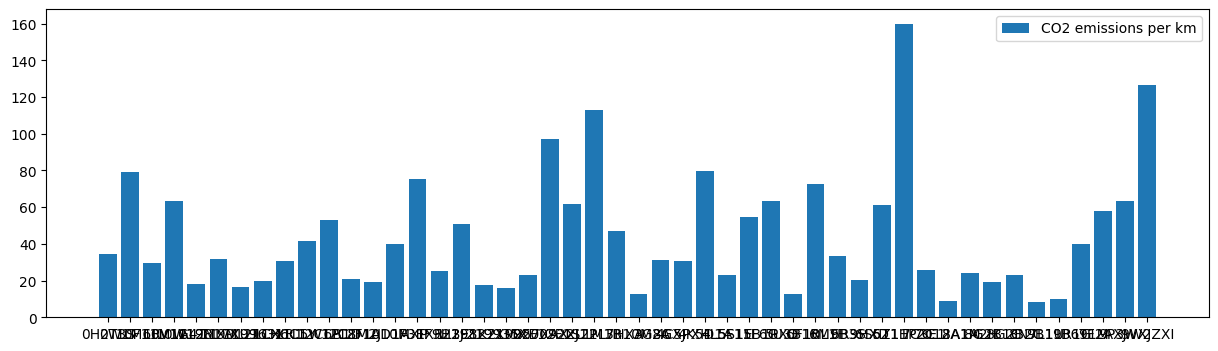

In [61]:
# Compute the emissions per km for each person
df['gCO2_per_km'] = df['gCO2'] / df['distance(m)'] * 1000
df['gCO2_per_km'] = df['gCO2_per_km'].replace([np.inf, -np.inf], np.nan)

# Plot the emissions per km for each person in a bar plot
df_co2_per_km = df.groupby('participant_id')['gCO2_per_km'].mean()
plt.figure(figsize=(15, 4))
plt.bar(df_co2_per_km.index, df_co2_per_km, label='CO2 emissions per km')
plt.legend()
plt.show()


/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


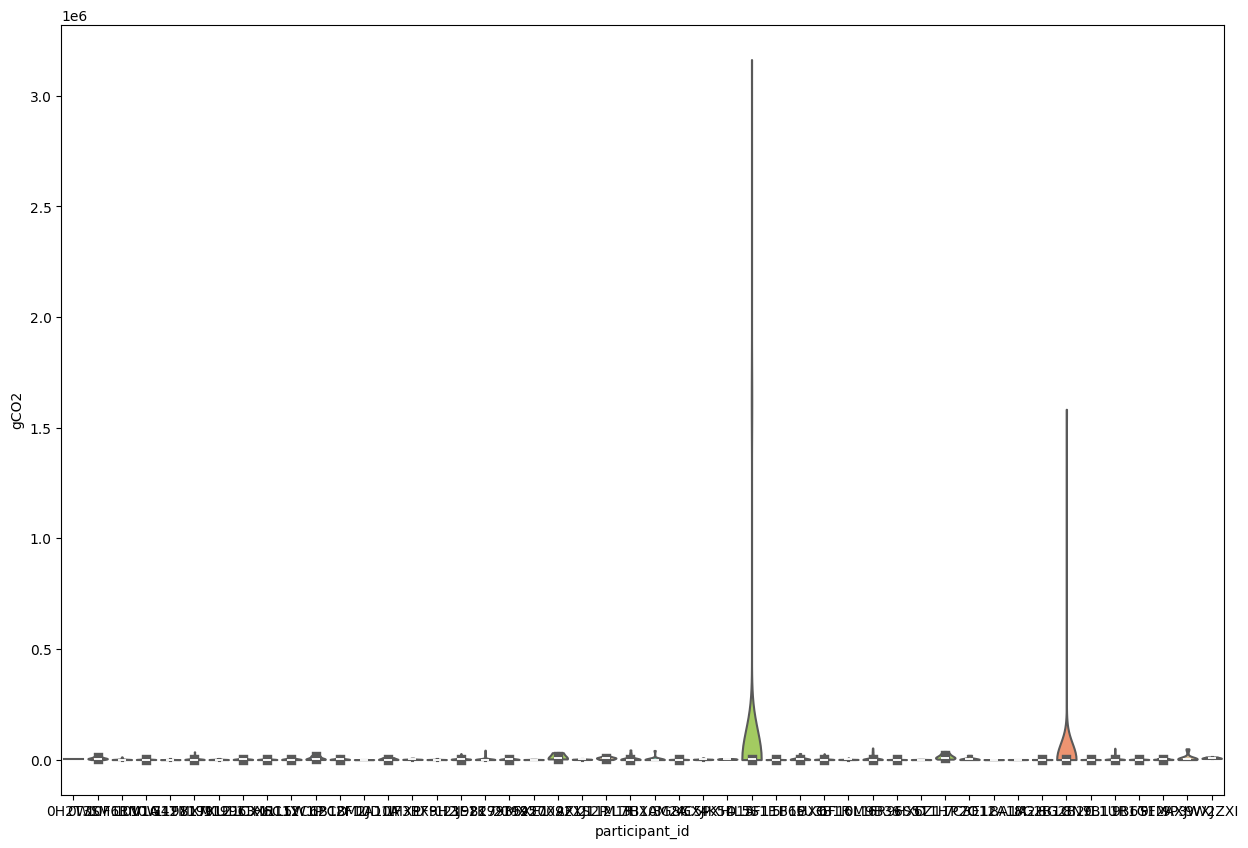

In [62]:
# Compute the emissions per day (using start time) for each person
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date
df_co2_per_day = df.groupby(['participant_id', 'day'])['gCO2'].sum()

# Plot emissions per day for each person in a violin plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='participant_id', y='gCO2', data=df_co2_per_day.reset_index(), inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='Set2', hue='participant_id')
plt.show()

In [21]:
# Reduce precision of geohash by 1 character for the rows where we covered a long distance (more than 10 km)
df['start_geohash'] = df.apply(lambda x: x['start_geohash'][:-1] if x['distance(m)'] > 10000 else x['start_geohash'], axis=1)
df['end_geohash'] = df.apply(lambda x: x['end_geohash'][:-1] if x['distance(m)'] > 10000 else x['end_geohash'], axis=1)

In [22]:
# Define colors for each mode of transport
alpha = 128
colors = {
    'WALKING': [70, 130, 180, alpha],      # Steel Blue (distinct blue for walking)
    'ON_BICYCLE': [100, 149, 237, alpha],  # Cornflower Blue (different blue for bike)
    'ELECTRIC_BIKE': [100, 149, 237, alpha],
    'SCOOTER': [100, 149, 237, alpha],
    'TRAIN': [0, 191, 255, alpha],         # Deep Sky Blue (different blue for train)
    'BUS': [255, 182, 193, alpha],         # Light Pink (distinct from car/tram/plane)
    'ELECTRIC_BUS': [255, 182, 193, alpha],
    'COACH': [255, 182, 193, alpha],
    'CAR': [255, 105, 180, alpha],        # Hot Pink (distinct for car)
    'ELECTRIC_CAR': [255, 105, 180, alpha],
    'HYBRID_CAR': [255, 105, 180, alpha],
    'TRAM': [255, 160, 122, alpha],       # Light Salmon Pink (distinct from bus and car)
    'PLANE': [255, 105, 180, alpha],      # Hot Pink (same as car, but could be changed if needed)
    'BOAT': [255, 105, 180, alpha],       # Hot Pink
    'BOAT_NO_ENGINE': [255, 105, 180, alpha],
    'DETECTION_ERROR': [0, 0, 0, alpha],  # Black
}

In [23]:
df.size

98153

In [24]:
# IF two movements from the same user have the same start geohash and start time, we should merge them into a single movement (keep the one with the highest distance)
df['start_time'] = pd.to_datetime(df['start_time'])

# Group by participant_id, start_geohash, start_time and maximum distance, keep all the other data from the row with the maxium distance
df = df.groupby(['participant_id', 'start_geohash', 'start_time'])['distance(m)'].max().reset_index().merge(df, on=['participant_id', 'start_geohash', 'start_time', 'distance(m)'])

In [25]:
df.size

72622

In [142]:
# Merge consecutive movements with the same mode of transport
def merge_consecutive_movements(df, time_min):
    # Group movements by participant and mode of transport, and sort by start time
    df = df.sort_values(['participant_id', 'mean_of_transport', 'start_time_precise'])

    # Calculate time difference between end time of one movement and start time of the next
    df['prev_end_time'] = df.groupby(['participant_id', 'mean_of_transport'])['end_time_precise'].shift()
    df['time_diff'] = (df['start_time_precise'] - pd.to_datetime(df['prev_end_time'])).dt.total_seconds() / 60

    # Create a new column to store the group number
    df['group'] = (df['time_diff'] > time_min).cumsum()

    # Group by participant, mode of transport and group number, and calculate the start and end time of the group
    return df.groupby(['participant_id', 'mean_of_transport', 'group']).agg(
        start_time_precise=('start_time_precise', 'first'),
        end_time_precise=('end_time_precise', 'last'),
        start_geohash=('start_geohash', 'first'),
        end_geohash=('end_geohash', 'last'),
        distance=('distance(m)', 'sum'),
        gCO2=('gCO2', 'sum')
    ).reset_index()

In [ ]:
df = merge_consecutive_movements(df, 60)

In [32]:
# Get only the rows with distance smaller than 10km
'''
df_copy = df.copy()
df = df[df['distance(m)'] < 10000]
'''

"\ndf_copy = df.copy()\ndf = df[df['distance(m)'] < 10000]\n"

In [ ]:
# Get only the rows with distance bigger than 10km

df = df_copy.copy()
df_copy = df.copy()
df = df[df['distance(m)'] > 10000]


In [34]:
# Process all paths in one step
df['start_coords'] = df['start_geohash'].apply(geohash_to_coordinate)
df['end_coords'] = df['end_geohash'].apply(geohash_to_coordinate)

# Add slight offsets to avoid overlaps
df['start_coords'] = df['start_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])
df['end_coords'] = df['end_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])

'''
# Add random height to the start and end coordinates
df['start_coords'] = df['start_coords'].apply(lambda x: [x[0], x[1], random.randint(10000, 20000)])
df['end_coords'] = df['end_coords'].apply(lambda x: [x[0], x[1], random.randint(10000, 20000)])
'''

# Create data list for Pydeck
path_data = df[['start_coords', 'end_coords', 'mean_of_transport', 'participant_id']].copy()
path_data['color'] = path_data['mean_of_transport'].apply(lambda x: colors.get(x, [0, 0, 0])) # Default black for unknown transport
path_data['color_start'] = path_data['color'].apply(lambda x: [xi * 0.7 for xi in x])  # Slightly darker starting color

# Pydeck ArcLayer (Curved Lines)
layer = pdk.Layer(
    "ArcLayer",
    data=path_data,
    get_source_position="start_coords",
    get_target_position="end_coords",
    get_source_color="color_start",
    get_target_color="color",
    get_color="color", # for linelayer
    get_width=1,
    get_height = 1, # Change the height of the arc, negative values make it go down
    pickable=True,
    auto_highlight=True,
)

# Define map view
view_state = pdk.ViewState(
    latitude=df['start_coords'].iloc[0][1],  # Center on first start point
    longitude=df['start_coords'].iloc[0][0],
    zoom=8,
    pitch=80,  # Adds some 3D depth for better arc visibility
)

# Render and save
deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{participant_id} - {mean_of_transport}"})
deck.to_html("maps/paths_map_mot.html")

# Open in browser
!open -a Arc maps/paths_map_mot.html

In [71]:
# Group trips that were from the same start and end geohash and vehicle, to reduce clutter
grouped = df.groupby(['start_geohash', 'end_geohash', 'mean_of_transport']).size().reset_index(name='counts')

# Get coordinates from geohashes
grouped['start_coords'] = grouped['start_geohash'].apply(geohash_to_coordinate)
grouped['end_coords'] = grouped['end_geohash'].apply(geohash_to_coordinate)

# Add slight offsets to avoid overlaps
grouped['start_coords'] = grouped['start_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])
grouped['end_coords'] = grouped['end_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])

# Create data list for Pydeck
path_data = grouped[['start_coords', 'end_coords', 'mean_of_transport', 'counts']].copy()
path_data['color'] = path_data['mean_of_transport'].apply(lambda x: colors.get(x, [0, 0, 0])) # Default black for unknown transport
path_data['color_start'] = path_data['color'].apply(lambda x: [xi * 0.7 for xi in x])  # Slightly darker starting color

# Get maxium count for scaling - then scale with a log scale, with minimum 1 width and maximum 5
max_count = path_data['counts'].max()
path_data['width'] = path_data['counts'].apply(lambda x: max(1, min(5, math.log(x + 1) / math.log(max_count + 1) * 5)))

# Pydeck ArcLayer (Curved Lines)
layer = pdk.Layer(
    "ArcLayer",
    data=path_data,
    get_source_position="start_coords",
    get_target_position="end_coords",
    get_source_color="color_start",
    get_target_color="color",
    get_width="width",  # Scale width based on counts
    pickable=True,
    auto_highlight=True,
)

# Define map view
view_state = pdk.ViewState(
    latitude=df['start_coords'].iloc[0][1],  # Center on first start point
    longitude=df['start_coords'].iloc[0][0],
    zoom=8,
    pitch=30,  # Adds some 3D depth for better arc visibility
)

# Render and  save
deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{mean_of_transport} - {counts}"})
deck.to_html("maps/paths_map_mot_grouped.html")

# Open in browser
!open -a Arc maps/paths_map_mot_grouped.html

In [72]:
# Print distances by train, average, median and standard deviation
train = df[df['mean_of_transport'] == 'TRAIN']['distance(m)']

print('Train distances:')
print('Average:', train.mean())
print('Median:', train.median())

print(train.describe())

print(train)

Train distances:
Average: 35832.89820359281
Median: 26769.0
count      1169.000000
mean      35832.898204
std       39685.264692
min         264.000000
25%        7643.000000
50%       26769.000000
75%       48681.000000
max      311709.000000
Name: distance(m), dtype: float64
0        49134
4        19710
8        20679
28       16209
97      109620
         ...  
6335     23989
6337     57321
6354     20223
6433     66371
6437     29339
Name: distance(m), Length: 1169, dtype: int64


# Create a Origin-Destination (OD) Matrix by city/village

In [320]:
# Merge consecutive movements with the same mode of transport
df = merge_consecutive_movements(df, 60)

In [321]:
df

,participant_id,mean_of_transport,group,start_time_precise,end_time_precise,start_geohash,end_geohash,distance,gCO2
0,0H2T3S,BUS,0,2025-01-28 17:03:28,2025-01-28 17:34:50,u0qj6w,u0qj5x,8568,1130
1,0H2T3S,TRAIN,0,2025-01-28 16:07:52,2025-01-28 16:53:06,u0mgth,u0qjd2,49134,343
2,0H2T3S,WALKING,0,2025-01-28 16:57:29,2025-01-28 17:48:06,u0qjd2,u0qj78,2052,0
3,0W1M6R,CAR,0,2024-10-18 09:27:53,2024-10-18 10:14:53,u0qnnx,u0qns8,10433,1939
4,0W1M6R,CAR,1,2024-10-18 11:35:14,2024-10-18 12:01:16,u0qns8,u0qnnx,10100,1878
...,...,...,...,...,...,...,...,...,...
7462,9W2ZXI,CAR,7186,2025-02-03 16:35:47,2025-02-03 17:52:55,u0mupy,u0mupy,31377,5835
7463,9W2ZXI,CAR,7187,2025-02-04 15:47:32,2025-02-04 17:33:32,u0qnnz,u0mupy,21895,4071
7464,9W2ZXI,TRAIN,7187,2025-02-04 05:49:31,2025-02-04 07:02:31,u0mupv,u0qnnx,66371,464
7465,9W2ZXI,TRAIN,7188,2025-02-04 16:36:56,2025-02-04 17:15:57,u0qjd2,u0mupy,29339,205


In [322]:
# Load swiss communes from geopackage
communes = gpd.read_file('data/AMTOVZ_SHP_LV95/AMTOVZ_LOCALITY.shp')

In [323]:
communes

,LOCALITYID,NAME,SHORTNAME,INDEXNAME,LANGUAGE,STATUS,INMODIFICA,VALIDITY,MODIFIED,SHAPE_AREA,SHAPE_LEN,geometry
0,036C7990-5F3C-47B6-B631-EBCE5C00B3D5,Sigigen,Sigigen,Sigigen,DE,REAL,FALSE,2008-07-01,2020-06-23,9.021343e+06,17294.388338,"POLYGON ((2652986.713 1211175.855, 2652957.958..."
1,9ACFF1C1-EFF4-470C-AC30-3DDED3D48848,Gündisau,Gündisau,Gündisau,DE,REAL,FALSE,2011-05-01,2021-01-26,3.480031e+06,9433.884983,"POLYGON ((2703275.389 1252023.596, 2703279.729..."
2,EA22EC8E-4896-4085-997A-75706EC8A610,Le Prese,Le Prese,Prese,IT,REAL,FALSE,2008-07-01,2021-02-10,2.594666e+07,28915.816357,"POLYGON ((2803556.980 1131931.774, 2803768.388..."
3,228A653B-E8CB-468A-A375-BE4E3A166CEE,Herrliberg,Herrliberg,Herrliberg,DE,REAL,FALSE,2008-07-01,2024-02-28,1.058630e+07,17747.466037,"POLYGON ((2686888.836 1238221.854, 2687715.974..."
4,B6CEDE71-D49A-43DD-BC52-63828DA520C9,Grandvaux,Grandvaux,Grandvaux,FR,REAL,FALSE,2008-07-01,2025-02-26,4.358285e+06,11265.114285,"POLYGON ((2545940.659 1151783.320, 2546166.816..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3968,3784162E-9161-4CE5-9E54-9617E0B7E486,Eschlikon TG,Eschlikon TG,Eschlikon,DE,REAL,FALSE,2008-07-01,2020-12-17,5.536997e+06,18698.286016,"POLYGON ((2715866.848 1256189.346, 2715862.844..."
3969,DEA40FE1-8242-40C5-9D4F-BE01B6AB9021,Wallenwil,Wallenwil,Wallenwil,DE,REAL,FALSE,2008-07-01,2020-12-17,1.845030e+06,8090.058716,"POLYGON ((2713835.829 1256301.692, 2713838.530..."
3970,C854C132-8521-4D48-86A2-50C79AD4938A,Herrenhof,Herrenhof,Herrenhof,DE,REAL,FALSE,2008-07-01,2023-07-20,1.660492e+06,6942.976749,"POLYGON ((2736605.705 1273013.588, 2736474.571..."
3971,69F84791-0065-42D5-8CA8-3CBBA0D92EA7,Dällikon,Dällikon,Dällikon,DE,REAL,FALSE,2008-07-01,2017-08-21,4.506356e+06,9645.669488,"POLYGON ((2673890.596 1254172.412, 2673869.182..."


In [324]:
# Convert LV95 to WGS84
communes = communes.to_crs(epsg=4326)

communes

,LOCALITYID,NAME,SHORTNAME,INDEXNAME,LANGUAGE,STATUS,INMODIFICA,VALIDITY,MODIFIED,SHAPE_AREA,SHAPE_LEN,geometry
0,036C7990-5F3C-47B6-B631-EBCE5C00B3D5,Sigigen,Sigigen,Sigigen,DE,REAL,FALSE,2008-07-01,2020-06-23,9.021343e+06,17294.388338,"POLYGON ((8.13596 47.04950, 8.13558 47.04959, ..."
1,9ACFF1C1-EFF4-470C-AC30-3DDED3D48848,Gündisau,Gündisau,Gündisau,DE,REAL,FALSE,2011-05-01,2021-01-26,3.480031e+06,9433.884983,"POLYGON ((8.80705 47.41092, 8.80711 47.41088, ..."
2,EA22EC8E-4896-4085-997A-75706EC8A610,Le Prese,Le Prese,Prese,IT,REAL,FALSE,2008-07-01,2021-02-10,2.594666e+07,28915.816357,"POLYGON ((10.08145 46.30793, 10.08420 46.30809..."
3,228A653B-E8CB-468A-A375-BE4E3A166CEE,Herrliberg,Herrliberg,Herrliberg,DE,REAL,FALSE,2008-07-01,2024-02-28,1.058630e+07,17747.466037,"POLYGON ((8.58728 47.28917, 8.59832 47.29387, ..."
4,B6CEDE71-D49A-43DD-BC52-63828DA520C9,Grandvaux,Grandvaux,Grandvaux,FR,REAL,FALSE,2008-07-01,2025-02-26,4.358285e+06,11265.114285,"POLYGON ((6.73422 46.51516, 6.73719 46.51329, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3968,3784162E-9161-4CE5-9E54-9617E0B7E486,Eschlikon TG,Eschlikon TG,Eschlikon,DE,REAL,FALSE,2008-07-01,2020-12-17,5.536997e+06,18698.286016,"POLYGON ((8.97493 47.44629, 8.97488 47.44629, ..."
3969,DEA40FE1-8242-40C5-9D4F-BE01B6AB9021,Wallenwil,Wallenwil,Wallenwil,DE,REAL,FALSE,2008-07-01,2020-12-17,1.845030e+06,8090.058716,"POLYGON ((8.94804 47.44765, 8.94807 47.44769, ..."
3970,C854C132-8521-4D48-86A2-50C79AD4938A,Herrenhof,Herrenhof,Herrenhof,DE,REAL,FALSE,2008-07-01,2023-07-20,1.660492e+06,6942.976749,"POLYGON ((9.25499 47.59358, 9.25328 47.59476, ..."
3971,69F84791-0065-42D5-8CA8-3CBBA0D92EA7,Dällikon,Dällikon,Dällikon,DE,REAL,FALSE,2008-07-01,2017-08-21,4.506356e+06,9645.669488,"POLYGON ((8.41810 47.43420, 8.41782 47.43428, ..."


In [325]:
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import geohash2
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="geo_mapping")

# Function to get city from geohash
def geohash_to_city(lat, lon):
    for i in range(1, 5):
        try:
            location = geolocator.reverse((lat, lon), exactly_one=True, language='en')
            if location and "city" in location.raw["address"]:
                return location.raw["address"]["city"]
            elif location and "town" in location.raw["address"]:
                return location.raw["address"]["town"]
            elif location and "village" in location.raw["address"]:
                return location.raw["address"]["village"]
            return "Unknown"
        except:
            # Sleep 1s and try again
            time.sleep(1)
            continue
    return "Unknown"

# For a geohash, get the commune it is in
def geohash_to_commune(geohash):
    try:
        lat, lon = geolib.decode(geohash)
        point = gpd.GeoSeries([Point(lon, lat)])
        commune = communes[communes.contains(point.unary_union)].iloc[0]['NAME']
        return commune
    except Exception as e:
        return "Abroad"
        # If it didn't work, it is not in switzerland, so we want to find this using Nominatim
        #return geohash_to_city(lat, lon)

In [326]:
from tqdm import tqdm

geo_to_munic = {}

# Get all the geohashes in the dataframe
geohashes = pd.concat([df['start_geohash'], df['end_geohash']]).unique()

# Get the commune for each geohash
for geohash in tqdm(geohashes):
    geo_to_munic[geohash] = geohash_to_commune(geohash)

100%|██████████| 1395/1395 [00:05<00:00, 270.04it/s]


In [341]:
# Add commune to the dataframe by getting from the dictionary
df['start_commune'] = df['start_geohash'].map(geo_to_munic)
df['end_commune'] = df['end_geohash'].map(geo_to_munic)

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_21716/1031038484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_commune'] = df['start_geohash'].map(geo_to_munic)
/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_21716/1031038484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_commune'] = df['end_geohash'].map(geo_to_munic)


In [342]:
# Calculate travel duration (in seconds)
df["travel_time"] = (df["end_time_precise"] - df["start_time_precise"]).dt.total_seconds()

# Remove rows with a travel time that is slower than 1 km/h
df = df[df["travel_time"] < df["distance"] * 3.6]

# Group by OD pairs
od_matrix = df.groupby(["start_commune", "end_commune"]).agg(
    count=("participant_id", "count"),
    avg_time=("travel_time", "mean"),
    min_time=("travel_time", "min"),
    max_time=("travel_time", "max")
).reset_index()

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_21716/3388282384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["travel_time"] = (df["end_time_precise"] - df["start_time_precise"]).dt.total_seconds()


In [343]:
od_matrix

,start_commune,end_commune,count,avg_time,min_time,max_time
0,Aarau,Aarau,4,1516.000000,576.0,2518.0
1,Aarau,Ennetbaden,1,1699.000000,1699.0,1699.0
2,Aarau,Rotkreuz,9,3954.888889,2580.0,8263.0
3,Aarau,Zuchwil,1,2723.000000,2723.0,2723.0
4,Aarau,Zürich,1,1438.000000,1438.0,1438.0
...,...,...,...,...,...,...
915,Zürich,Wallisellen,1,1874.000000,1874.0,1874.0
916,Zürich,Weesen,1,2008.000000,2008.0,2008.0
917,Zürich,Wettswil,1,455.000000,455.0,455.0
918,Zürich,Winterthur,52,2165.403846,884.0,3712.0


In [344]:
# Get the list of cities that appear in rows with at least 20 counts
counts = od_matrix[od_matrix["count"] >= 20]
cities = list(set(counts["start_commune"]) | set(counts["end_commune"]))
cities

['Lenzerheide/Lai',
 'Givisiez',
 'Rotkreuz',
 'Bettmeralp',
 'Villars-sur-Glâne',
 'Abroad',
 'Luzern',
 'Genève',
 'Melchsee-Frutt',
 'Yverdon-les-Bains',
 'Ovronnaz',
 'Fribourg',
 'Lausanne',
 'Bern',
 'Kandersteg',
 'Schlieren',
 'Winterthur',
 'Ostermundigen',
 'Biel/Bienne',
 'Zürich',
 'Basel',
 'Liestal',
 'Nidau',
 'Nuglar',
 'Vals']

In [345]:
# Filter the OD matrix to only include the cities in the list
od_matrix_new = od_matrix[od_matrix["start_commune"].isin(cities) & od_matrix["end_commune"].isin(cities)]

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_21716/2807188529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_matrix_new.loc[:, "log_count"] = np.log(od_matrix_new["count"] + 1)


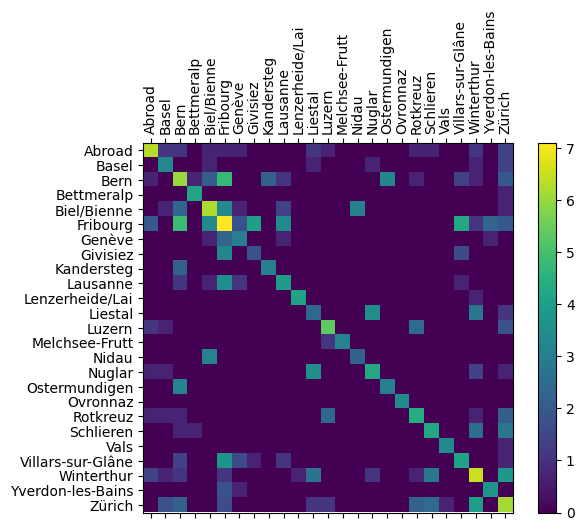

In [346]:
# Show heatmap of movements
od_matrix_new.loc[:, "log_count"] = np.log(od_matrix_new["count"] + 1)

# Get the list of cities
cities = sorted(cities)

# Create a matrix with the number of trips between each pair of cities
matrix = np.zeros((len(cities), len(cities)))

# Fill the matrix with the number of trips
for index, row in od_matrix_new.iterrows():
    start = cities.index(row["start_commune"])
    end = cities.index(row["end_commune"])
    matrix[start, end] = row["log_count"]

# Plot the matrix
fig, ax = plt.subplots()
mat = ax.matshow(matrix, cmap="viridis")
fig.colorbar(mat)
ax.set_xticks(range(len(cities)))
ax.set_xticklabels(cities, rotation=90)
ax.set_yticks(range(len(cities)))
ax.set_yticklabels(cities)
plt.show()

In [347]:
# Remove data with abroad communes from od_matrix_new
od_matrix_new = od_matrix_new[od_matrix_new["start_commune"] != "Abroad"]
od_matrix_new = od_matrix_new[od_matrix_new["end_commune"] != "Abroad"]

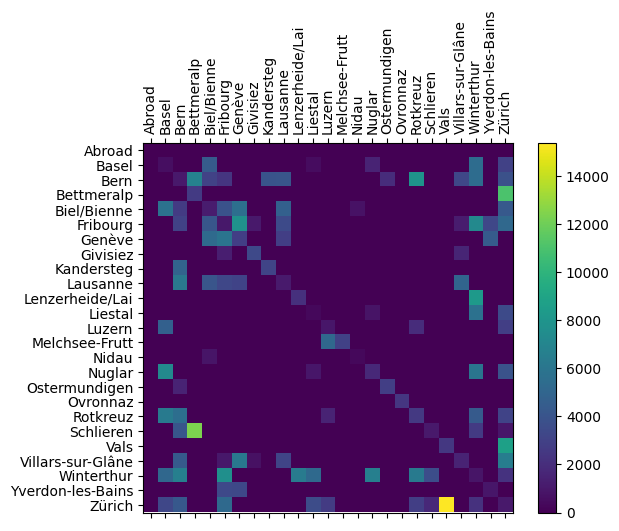

In [348]:
# Create a matrix with the average travel time between each pair of cities
matrix_time = np.zeros((len(cities), len(cities)))

# Fill the matrix with the average travel time
for index, row in od_matrix_new.iterrows():
    start = cities.index(row["start_commune"])
    end = cities.index(row["end_commune"])
    matrix_time[start, end] = row["avg_time"]

# Plot the matrix
fig, ax = plt.subplots()
mat = ax.matshow(matrix_time, cmap="viridis")
fig.colorbar(mat)
ax.set_xticks(range(len(cities)))
ax.set_xticklabels(cities, rotation=90)
ax.set_yticks(range(len(cities)))
ax.set_yticklabels(cities)
plt.show()

In [349]:
# Remove travels from a place to the same place
od_matrix_new = od_matrix_new[od_matrix_new["start_commune"] != od_matrix_new["end_commune"]]
od_matrix_new

,start_commune,end_commune,count,avg_time,min_time,max_time,log_count
56,Basel,Biel/Bienne,1,4412.000000,4412.0,4412.0,0.693147
58,Basel,Liestal,1,523.000000,523.0,523.0,0.693147
60,Basel,Nuglar,1,1512.000000,1512.0,1512.0,0.693147
61,Basel,Winterthur,1,5421.000000,5421.0,5421.0,0.693147
62,Basel,Zürich,3,2956.000000,2641.0,3160.0,1.386294
...,...,...,...,...,...,...,...
905,Zürich,Luzern,2,2670.000000,2333.0,3007.0,1.098612
909,Zürich,Rotkreuz,8,2856.375000,1665.0,4997.0,2.197225
910,Zürich,Schlieren,11,1767.909091,68.0,5737.0,2.484907
914,Zürich,Vals,1,15372.000000,15372.0,15372.0,0.693147


In [350]:
od_matrix_new.shape

(94, 7)

In [351]:
# Create temporary dataframe with the start and end communes swapped
'''
od_matrix_swapped = od_matrix_new.copy()
od_matrix_swapped["start_commune"] = od_matrix_new["end_commune"]
od_matrix_swapped["end_commune"] = od_matrix_new["start_commune"]

# Merge the two dataframes
od_matrix_merged = pd.concat([od_matrix_new, od_matrix_swapped])

# Group by OD pairs
od_matrix_grouped = od_matrix_merged.groupby(["start_commune", "end_commune"]).agg(
    count=("count", "sum"),
    avg_time=("avg_time", "mean"),
    min_time=("min_time", "min"),
    max_time=("max_time", "max")
).reset_index()

# Keep only the first row for each pair of communes
od_matrix_grouped = od_matrix_grouped.sort_values("count", ascending=False).drop_duplicates(["start_commune", "end_commune"])
'''

'\nod_matrix_swapped = od_matrix_new.copy()\nod_matrix_swapped["start_commune"] = od_matrix_new["end_commune"]\nod_matrix_swapped["end_commune"] = od_matrix_new["start_commune"]\n\n# Merge the two dataframes\nod_matrix_merged = pd.concat([od_matrix_new, od_matrix_swapped])\n\n# Group by OD pairs\nod_matrix_grouped = od_matrix_merged.groupby(["start_commune", "end_commune"]).agg(\n    count=("count", "sum"),\n    avg_time=("avg_time", "mean"),\n    min_time=("min_time", "min"),\n    max_time=("max_time", "max")\n).reset_index()\n\n# Keep only the first row for each pair of communes\nod_matrix_grouped = od_matrix_grouped.sort_values("count", ascending=False).drop_duplicates(["start_commune", "end_commune"])\n'

In [354]:
# Keep only cities that appear in rows with at least 20 counts
counts = od_matrix_new[od_matrix_new["count"] >= 30]
cities = list(set(counts["start_commune"]) | set(counts["end_commune"]))
cities

# Filter the OD matrix to only include the cities in the list
od_matrix_new = od_matrix_new[od_matrix_new["start_commune"].isin(cities) & od_matrix_new["end_commune"].isin(cities)]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
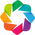

:Chord   [source,target]   (value)

In [355]:
import pandas as pd
import numpy as np
import holoviews as hv
from holoviews import dim

hv.extension('bokeh')

# Create a list of cities
cities = sorted(set(od_matrix_new["start_commune"]).union(set(od_matrix_new["end_commune"])))

# Create a DataFrame for links
links = [
    (row["start_commune"], row["end_commune"], row["count"])
    for _, row in od_matrix_new.iterrows()
]

# Convert to HoloViews DataFrame
chord = hv.Chord(pd.DataFrame(links, columns=["source", "target", "value"]))

# Styling with different color for each source
chord.opts(
    cmap='Category20', edge_color=dim('source').str(), 
    node_color=dim('index').str(), labels='index', width=800, height=800
)
chord